CS573100 Music Information Retrieval

DDL: 2023.5.9.

Description: Homework 2. Intrument and pitch classification.

Requirements:
1. Name you file as HW2_{student-id}.ipynb and submit to eeclass.
2. Strongly recommend writing the report on your jupyter notebook file.

### 1. Explain meaning of TinySol1 dataset’s track ID annotation

**Track ID: Cb-ord-A2-ff-1c-R100d**
* The track ID follows the format (INSTR)-ord-(PITCH)-(DYN)-(INSTANCE)-(MISC) where
    * INSTR is the abbreviation of the instrument
    * ord is the abbreviation for ordinario (the ordinary playing technique)
    * PITCH denotes the pitch of the musical note
    * DYN denotes the intensity dynamics, ranged from pp to ff
    * INSTANCE denotes additional information about the instrument being played
        * For bowed instruments, 1c, 2c, 3c, 4c denotes which string is being bowed
        * For wind instruments, alt1, alt2, denotes alternative instances of the note if the same note is played multiple times
        * N for not applicable
    * MISC denotes additional info
        * R stands for resampled, denotes that it is obtained by transforming a different audio clip
        * T stands for tuned, Because some pitches are out of tune
        * N for natural, meaning the note is distributed as it was recorded
* So this example corresponds to 
    * a contrabass sound
    * played in the ordinary playing technique
    * at pitch A2
    * with fortissimo dynamics
    * on the first string
    * resampled from a A#2 by lowering pitch by a semitone, i.e. 100 cents (R100d)

In [1]:
# Load TinySOL metadata
# Import mirdata library
import mirdata

# Initialize tinysol dat

tinysol_dataset = mirdata.initialize("tinysol")
# tinysol_dataset.download()
# Load tinysol metadata
tinysol_metadata = tinysol_dataset._metadata

### 2. Find audio file and plot

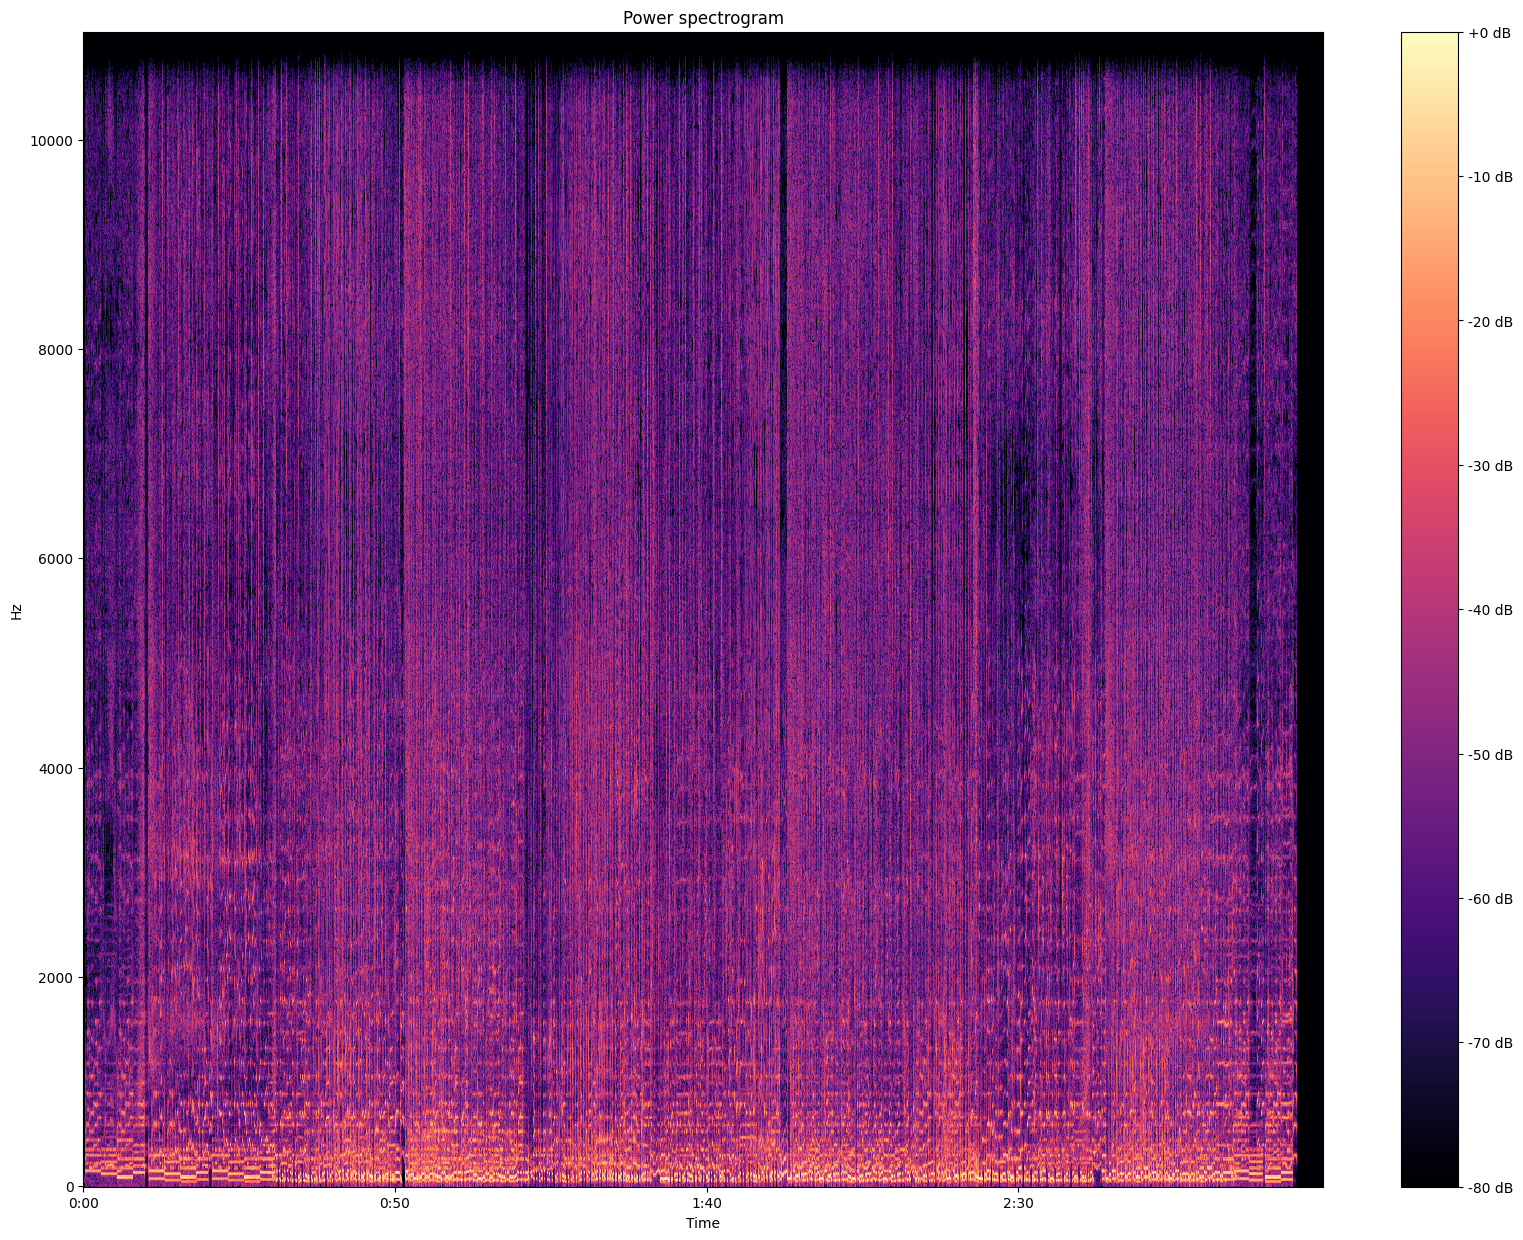

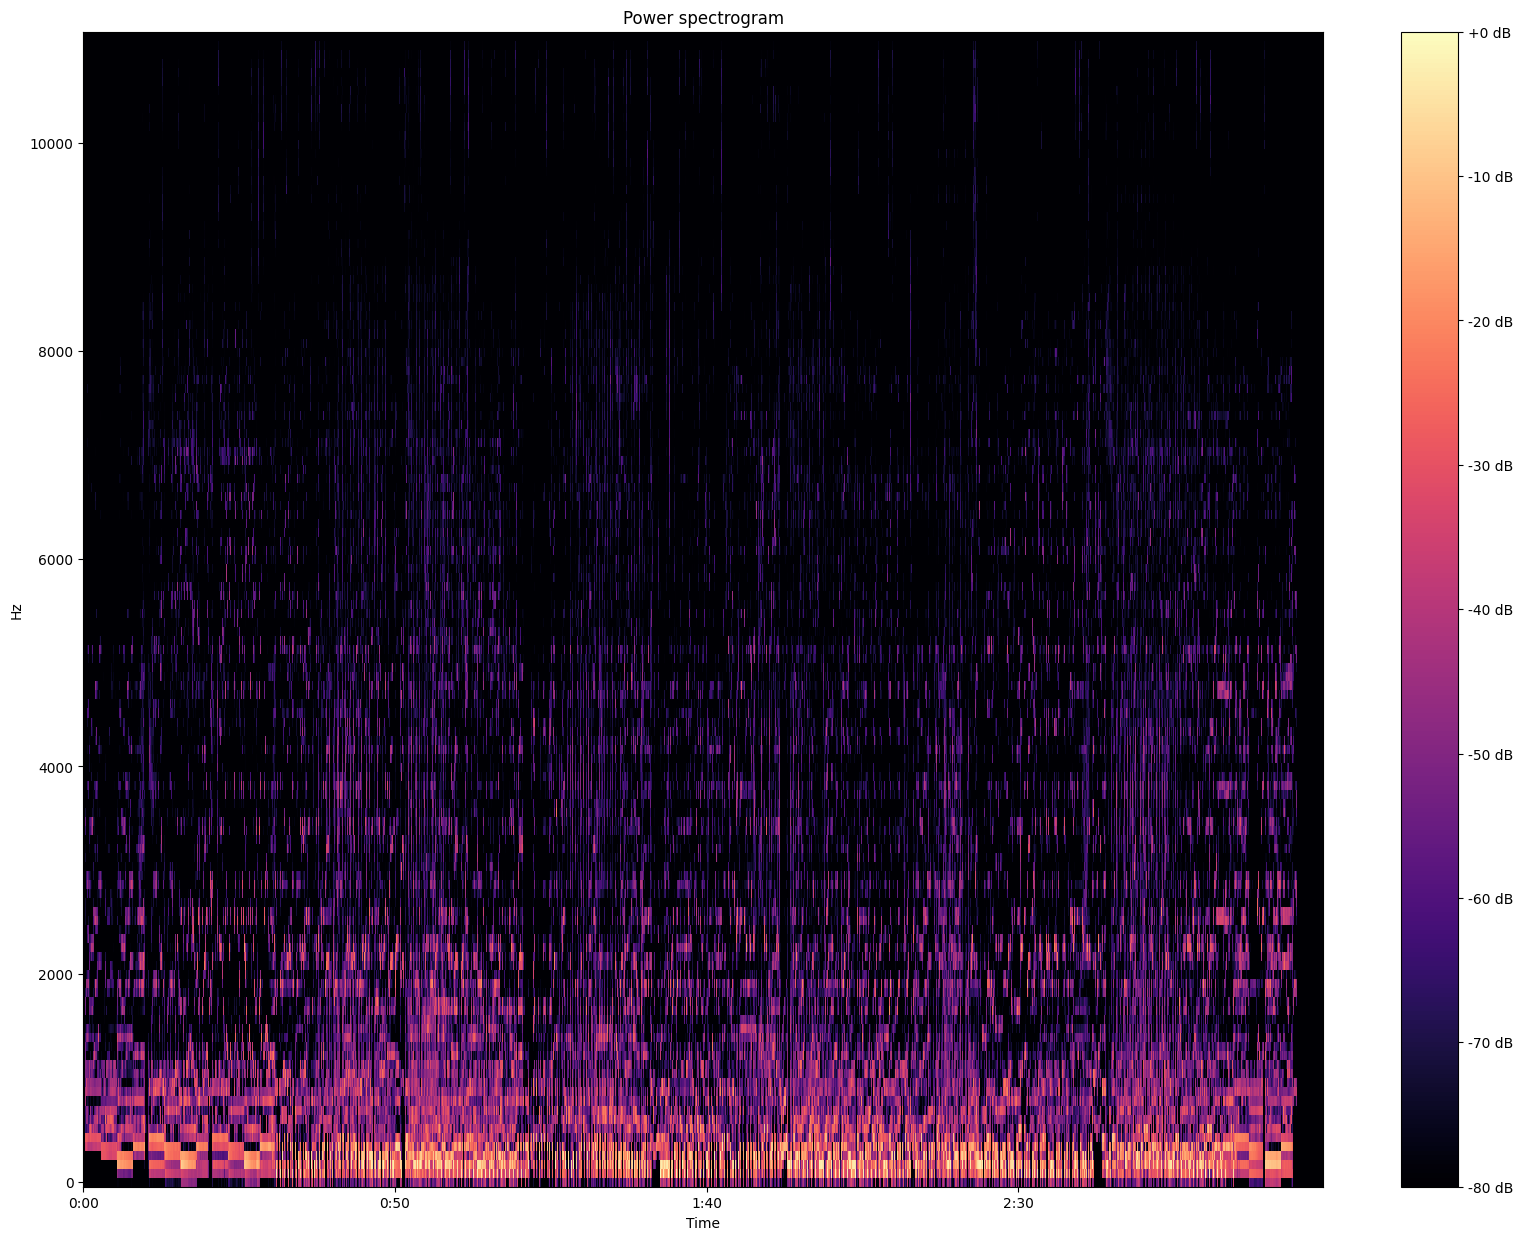

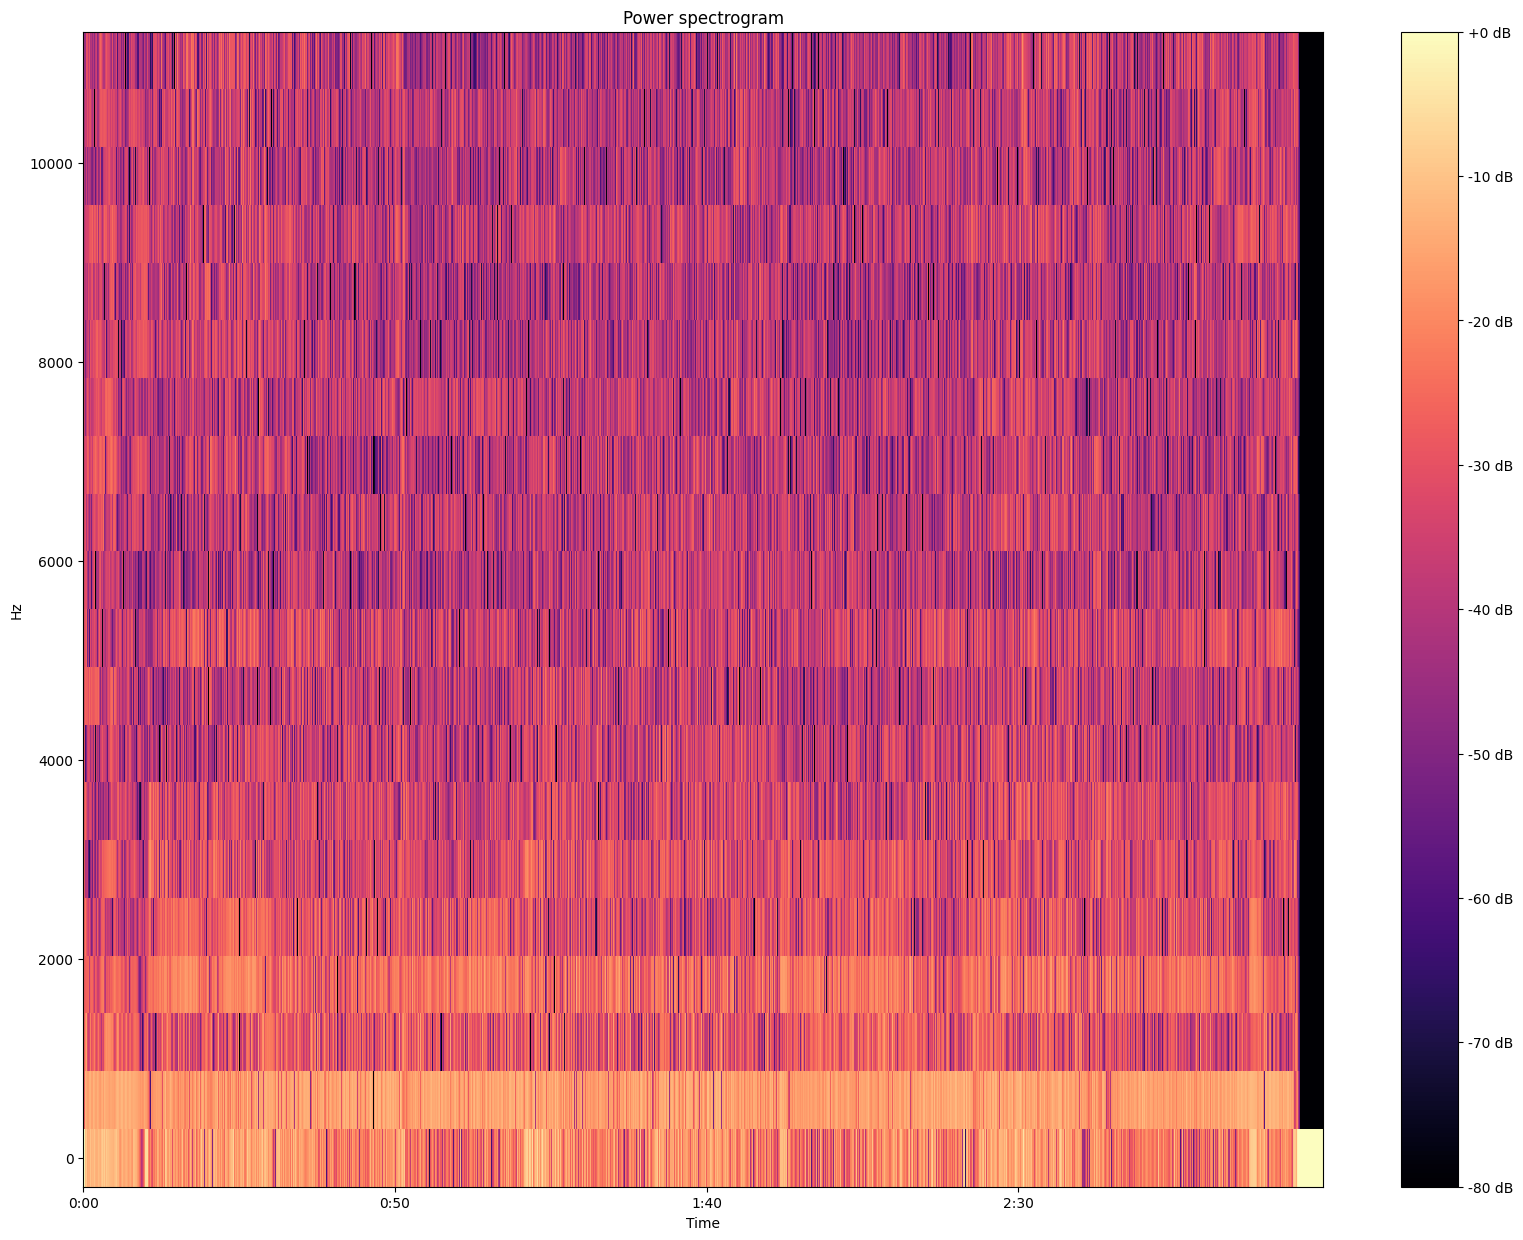

In [22]:
import librosa

def plot_feat(title, D):
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")

filename = 'PTX_Despacito_x_Shape_Of_You.wav'
y, sr = librosa.load(filename)

plot_feat('Spectrogram', librosa.stft(y=y))
plot_feat('Mel-spectrogram', librosa.feature.melspectrogram(y=y, sr=sr))
plot_feat('MFCC', librosa.feature.mfcc(y=y, sr=sr))

* Spectrogram: A spectrogram is a visual representation of the frequencies that make up an audio signal as it changes over time. It is obtained by applying a Fourier Transform to successive short-time windows of the signal and then plotting the resulting spectrum over time. The resulting spectrogram provides information about the frequency content of the audio signal over time, and it is commonly used for visualizing speech and music signals.

* Mel-spectrogram: A mel-spectrogram is a spectrogram that has been transformed to a scale that is more perceptually uniform. This transformation is achieved by applying a filterbank that mimics the behavior of the human auditory system. Mel-spectrograms are commonly used in audio processing tasks that require a more perceptually relevant representation of the audio signal, such as speech recognition and music genre classification.

* MFCC: MFCC stands for Mel-frequency cepstral coefficients, which are a type of feature extracted from the mel-spectrogram. The MFCCs are obtained by taking the logarithm of the mel-spectrogram, followed by a Discrete Cosine Transform (DCT). The resulting coefficients are highly correlated with the perceptual features of the audio signal, such as the timbre and pitch. MFCCs are commonly used in speech and music processing tasks, such as speaker identification, music genre classification, and instrument recognition.

I choose MFCC because it is a popular choice for instrument and pitch classification due to its ability to capture perceptual features of the audio signal. Pitch is a critical aspect of music, and MFCCs have been shown to capture pitch information effectively. In addition, different musical instruments have distinct timbres, and the MFCCs can capture these timbral differences as well.

#### Feature Extraction

In [3]:
import numpy as np
# Create empty lists to store MFCC features and labels
mfccs_list = []
instrument_list = []
pitch_list = []

# Iterate through all the tracks in the dataset
for track_id in tinysol_dataset.track_ids:
  
  # Load a track by its ID
  track = tinysol_dataset.track(track_id)

  # Print some track information
  # print("----------------------")
  # print("Track ID:", track.track_id)
  # print("Instrument name:", track.instrument_full)
  # print("Pitch class:", track.pitch)
  #print("Dynamics:", track.dynamics)

  # Load and play the audio file of the track
  audio, sr = track.audio
  #track.play_audio()

  # TODO:  IMPLEMENT FEATURE EXTRACTION
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=200)
  feat = np.average(mfcc, axis=1)
  # Append the MFCC features and labels to the lists
  mfccs_list.append(feat)
  instrument_list.append(track.instrument_full)
  pitch_list.append(track.pitch)

In [4]:
# Convert the lists to numpy arrays for tensorflow compatibility[^2^][2] [^3^][3]
mfccs_array = np.array(mfccs_list)
instrument_array = np.array(instrument_list)
pitch_array = np.array(pitch_list)

In [5]:
from sklearn import preprocessing

#### Split Training Set and Testing Set 

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_instrument, y_test_instrument, y_train_pitch, y_test_pitch = train_test_split(
    mfccs_array, instrument_array, pitch_array,test_size=0.2, random_state=23) # DON'T Modify Random_state!


In [8]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          size="small",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')
    
    if size == "small":
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    elif size == "large":
        plt.rcParams["figure.figsize"] = (20,15)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
def print_evaluation(ground_truth, pred):
    accuracy = accuracy_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred, average='micro') #can try other ave method
    precision = precision_score(ground_truth, pred, average='micro')
    print('ACC = ',  round(accuracy,3))
    print('precision = ', round(precision,3))
    print('recall = ', round(recall, 3))

In [10]:
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

### 3. Instrument Classification

In [11]:
instr_le = preprocessing.LabelEncoder()
instr_le.fit_transform(instrument_array)
instr_classes = instr_le.classes_

---- svm evaluation ----
ACC =  0.664
precision =  0.664
recall =  0.664
Confusion matrix


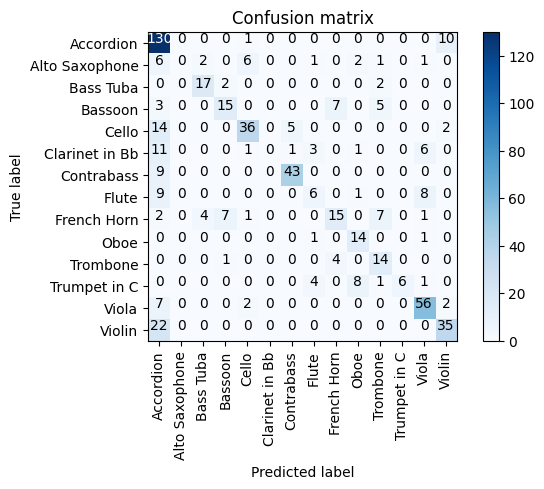

---- decision tree evaluation ----
ACC =  0.806
precision =  0.806
recall =  0.806
Confusion matrix


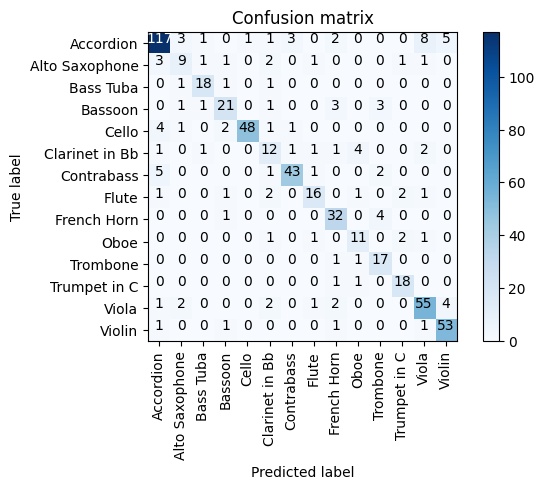

---- mlp evaluation ----
ACC =  0.93
precision =  0.93
recall =  0.93
Confusion matrix


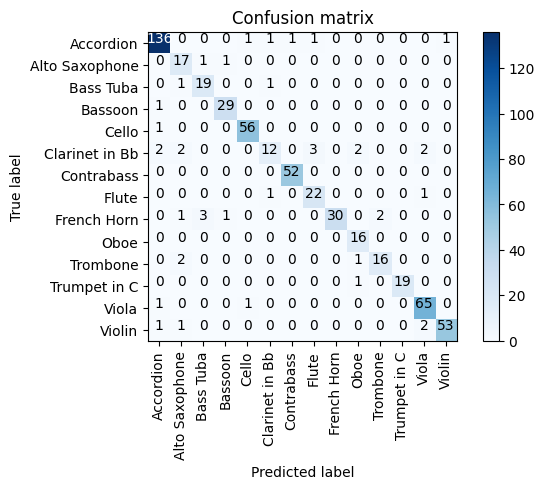

In [12]:
svm = SVC()
dt = DecisionTreeClassifier()
mlp = MLPClassifier()

svm.fit(X_train, y_train_instrument)
dt.fit(X_train, y_train_instrument)
mlp.fit(X_train, y_train_instrument)

print("---- svm evaluation ----")
predicts = svm.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

print("---- decision tree evaluation ----")
predicts = dt.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

print("---- mlp evaluation ----")
predicts = mlp.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

#### Observation on Instrument Classification
* Accuracy,Precision and recall: MLP > Decision Tree > SVM

### 4. Pitch Classification

In [13]:
pitch_le = preprocessing.LabelEncoder()

pitch_array = pitch_le.fit_transform(pitch_array)
pitch_classes = pitch_le.classes_
print(pitch_classes)

['A#1' 'A#2' 'A#3' 'A#4' 'A#5' 'A#6' 'A#7' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6'
 'A7' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'C#2' 'C#3' 'C#4' 'C#5' 'C#6'
 'C#7' 'C#8' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'D#2' 'D#3' 'D#4' 'D#5'
 'D#6' 'D#7' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'E1' 'E2' 'E3' 'E4' 'E5' 'E6'
 'E7' 'F#1' 'F#2' 'F#3' 'F#4' 'F#5' 'F#6' 'F#7' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'G#1' 'G#2' 'G#3' 'G#4' 'G#5' 'G#6' 'G#7' 'G1' 'G2' 'G3' 'G4'
 'G5' 'G6' 'G7']


---- svm pitch eval ----
ACC =  0.897
precision =  0.897
recall =  0.897
Confusion matrix


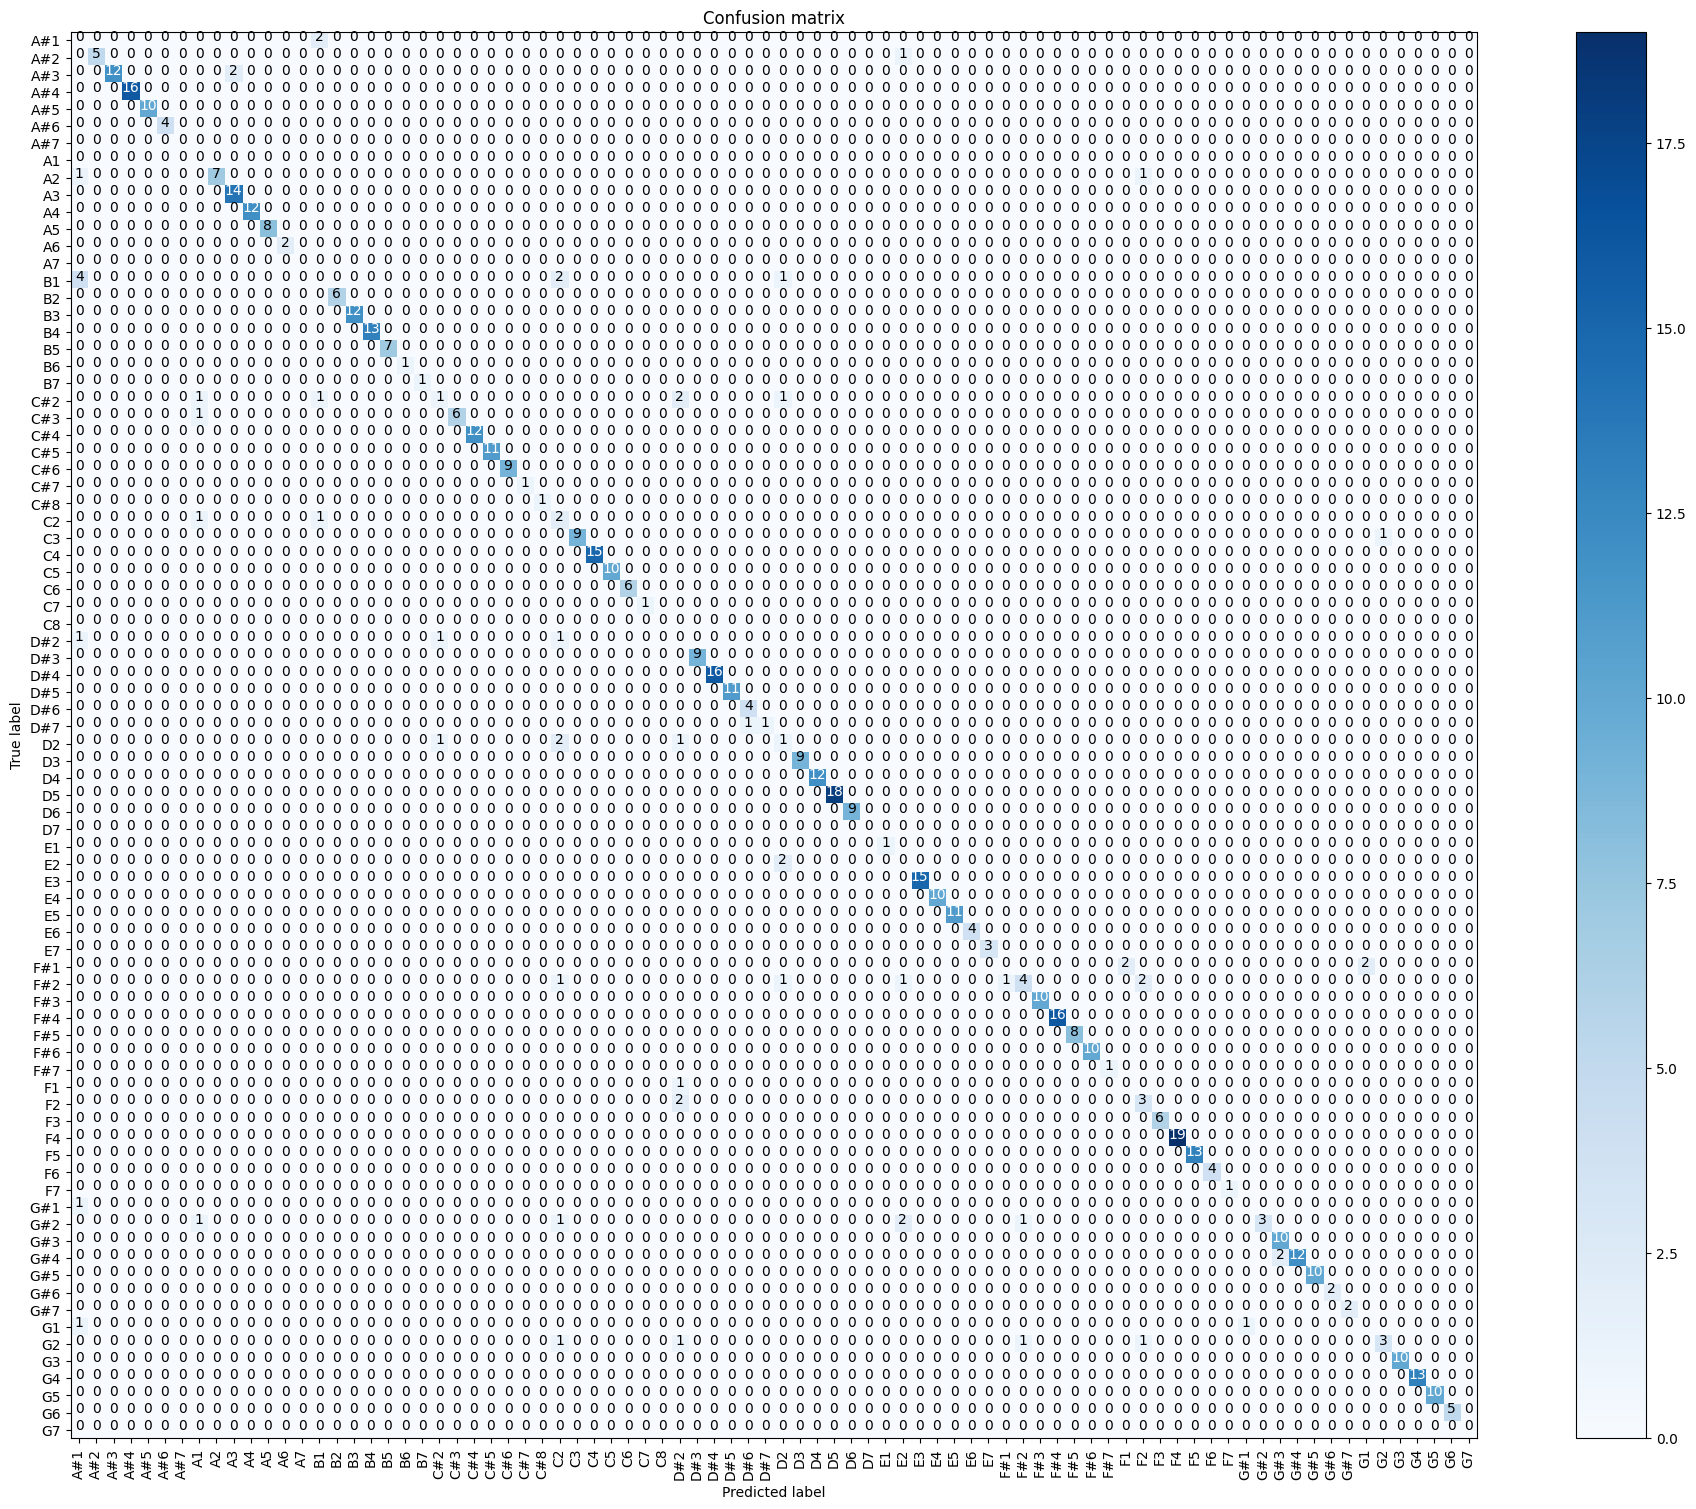

---- dt pitch eval ----
ACC =  0.892
precision =  0.892
recall =  0.892
Confusion matrix


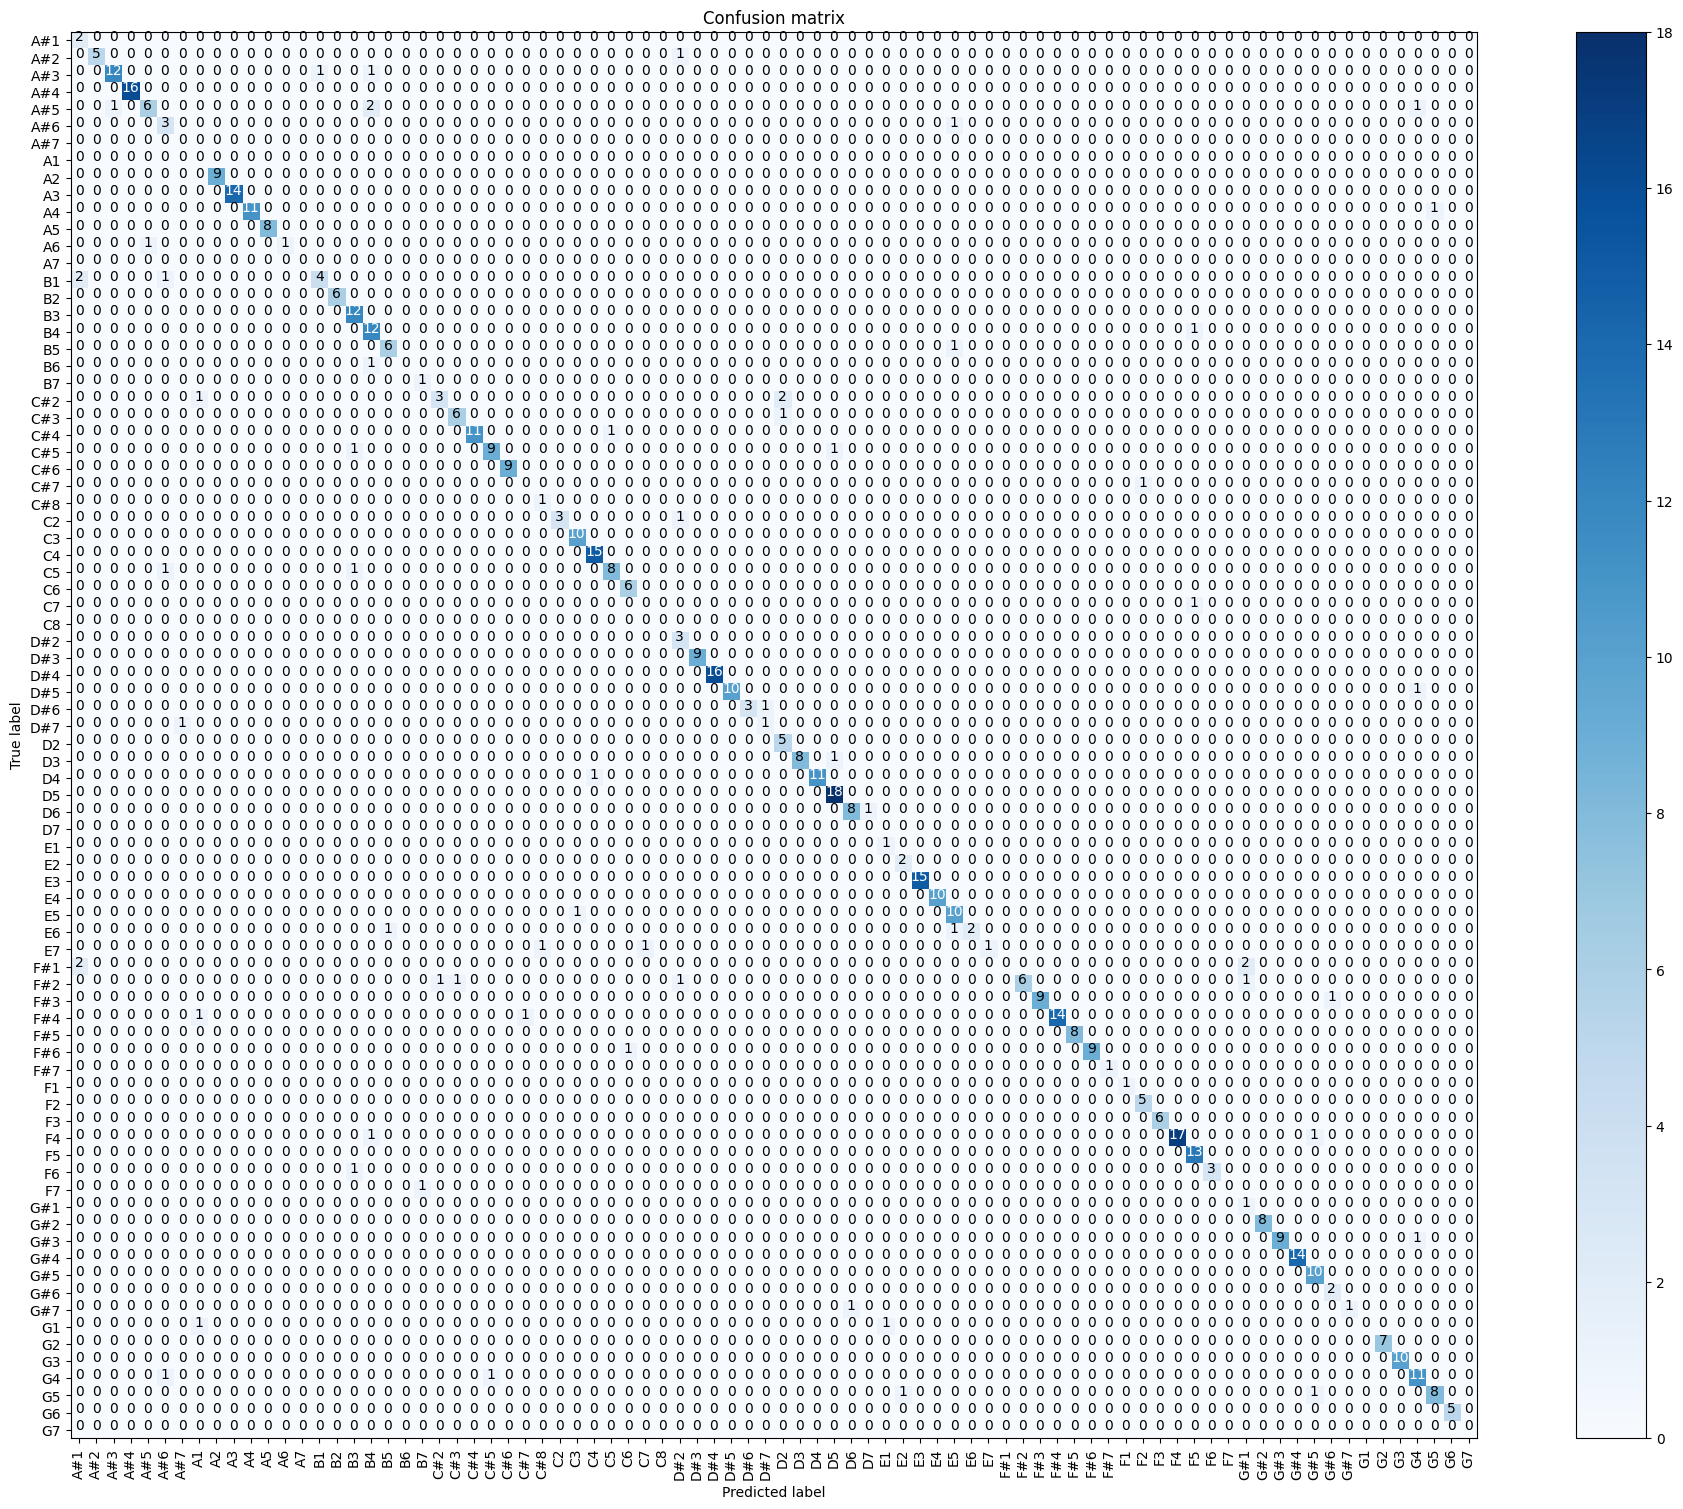

---- mlp pitch eval ----
ACC =  0.985
precision =  0.985
recall =  0.985
Confusion matrix


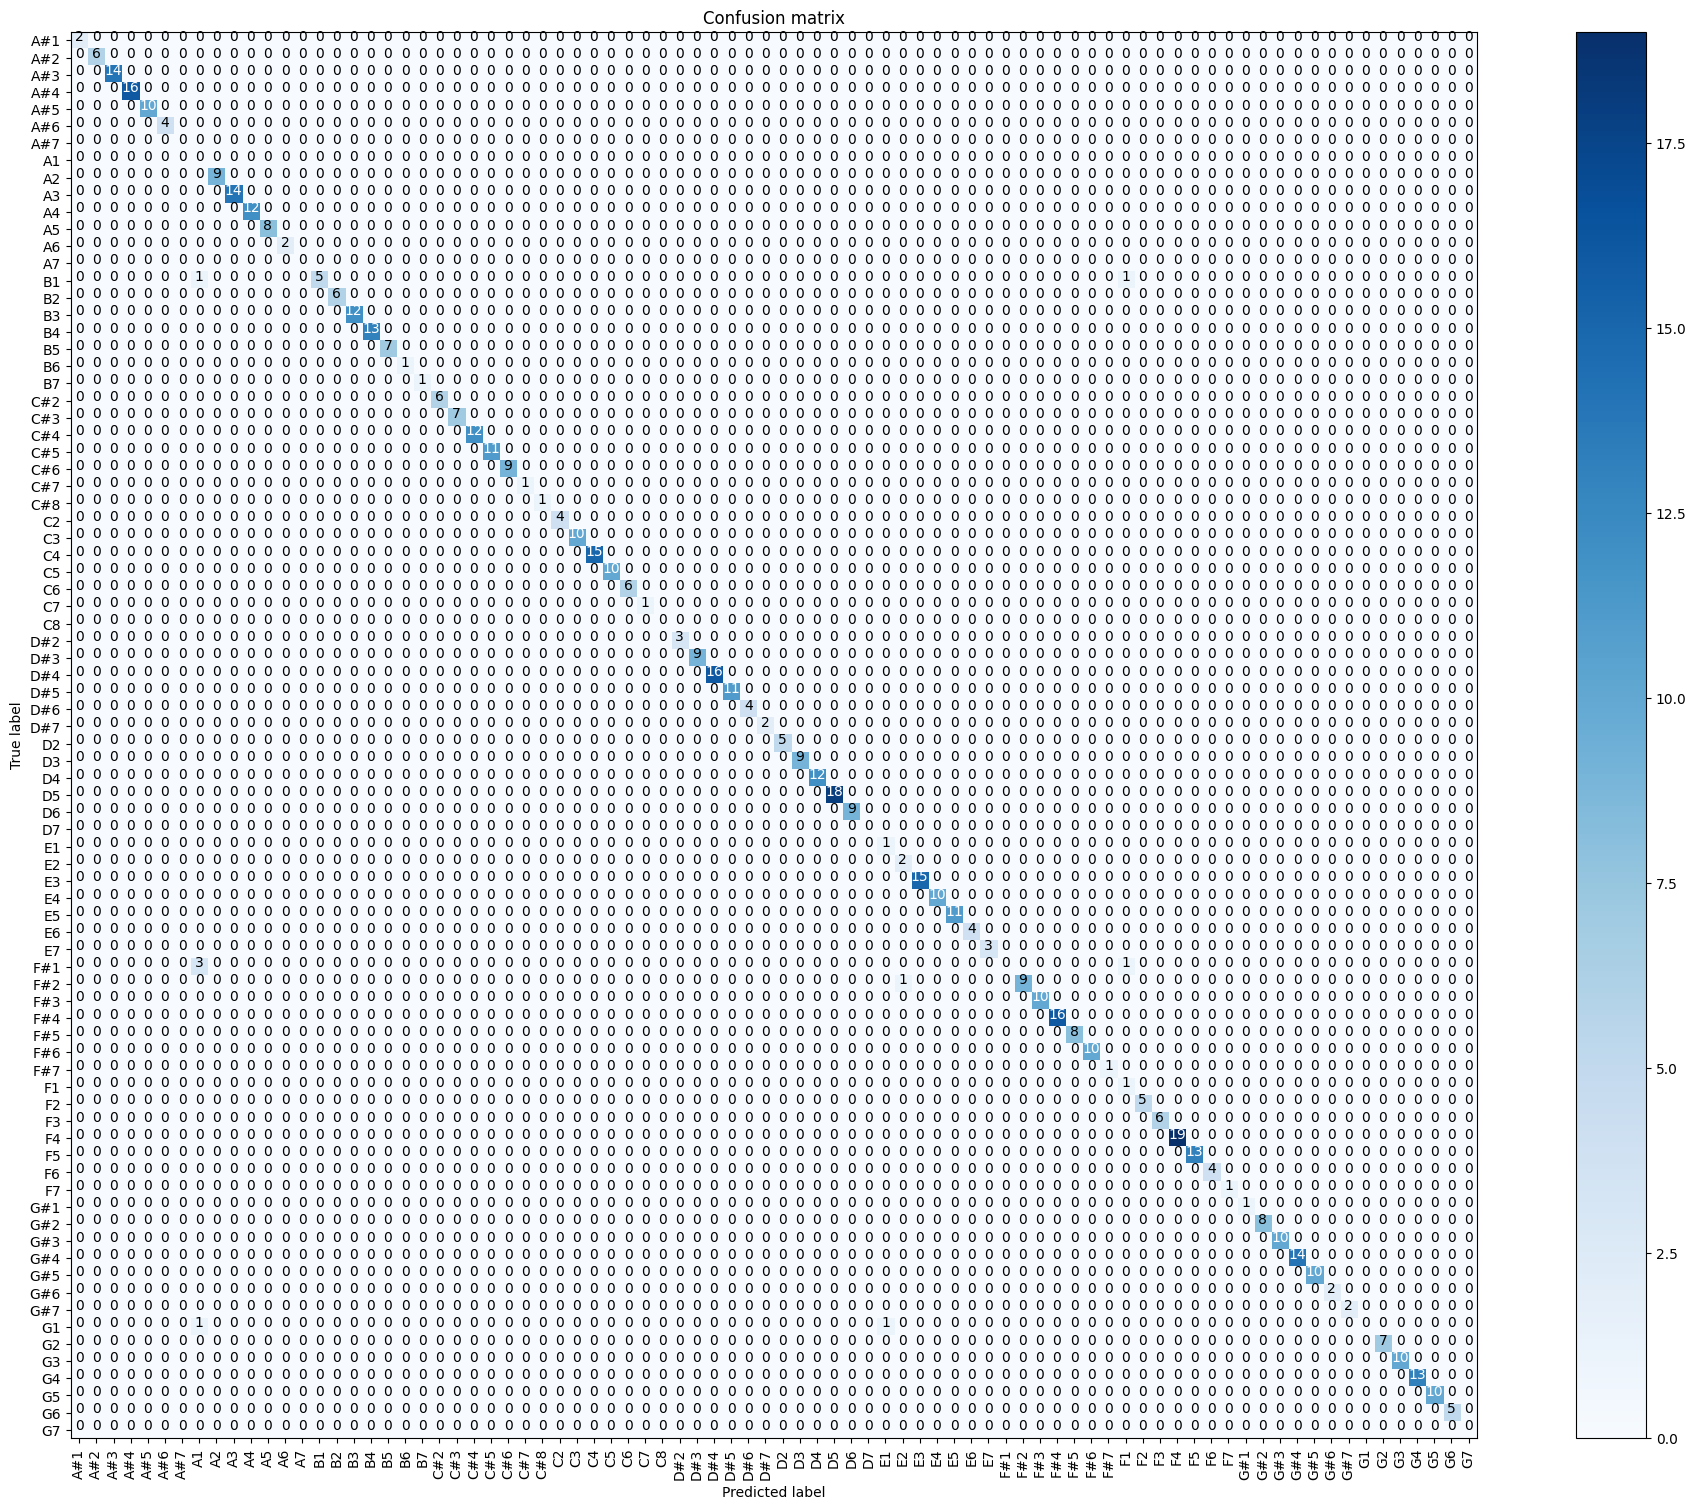

In [43]:
svm_pitch = SVC()
dt_pitch = DecisionTreeClassifier()
mlp_pitch = MLPClassifier()

svm_pitch.fit(X_train, y_train_pitch)
dt_pitch.fit(X_train, y_train_pitch)
mlp_pitch.fit(X_train, y_train_pitch)


print("---- svm pitch eval ----")
predicts = svm_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) ,pitch_classes, size="large")

print("---- dt pitch eval ----")
predicts = dt_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) , pitch_classes,  size="large")

print("---- mlp pitch eval ----")
predicts = mlp_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) , pitch_classes,  size="large")

#### Observation on Pitch Classification
* Accuracy,Precision and recall: MLP > Decision Tree > SVM

### 5. Grid Search to find the best hyperparameters based on the cross-validation score
* For SVM, please tune hyperparameters C and Gamma. 
* For Decision Tree, please tune hyperparameters Criterion and Maximum Depth. 
* For MLP, please change the Hidden Layer Sizes and the strength of the L2 Regularization Term.

#### Tune Hyperparameters for instrument classification

In [44]:
from sklearn.model_selection import GridSearchCV

svm_gs= GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}).fit(X_train, y_train_instrument)
svm_gs.best_params_

{'C': 10, 'gamma': 0.0001}

In [50]:
dt_gs = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid={'max_depth': [10,11,12,13,14,15],
    'criterion': ['gini', 'entropy']}).fit(X_train, y_train_instrument)
dt_gs.best_params_

{'criterion': 'entropy', 'max_depth': 14}

In [51]:
mlp_gs = GridSearchCV(
    estimator=MLPClassifier(max_iter=400), 
    param_grid={'hidden_layer_sizes': [(10,), (50,), (100,)], 'alpha':[0.001, 0.01, 0.1, 1, 10]}).fit(X_train, y_train_instrument)
mlp_gs.best_params_

/media/hank/01D961F9F06CBF70/Data/academic/NTHU/碩一下/音樂資訊檢索/homeworks/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/hank/01D961F9F06CBF70/Data/academic/NTHU/碩一下/音樂資訊檢索/homeworks/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/hank/01D961F9F06CBF70/Data/academic/NTHU/碩一下/音樂資訊檢索/homeworks/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/hank/01D961F9F06CBF70/Data/academic/NTHU/碩一下/音樂資訊檢索/homeworks/env/lib/python3.10/site-packages/sklearn/neural_network/_m

In [39]:
# Create a model for Intstrument Classification
svm = SVC(C=10, gamma=0.0001)
dt = DecisionTreeClassifier(criterion = "entropy", max_depth=14)
mlp = MLPClassifier()

# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

  # TODO: Train your model using the train subset
  svm.fit(X_train_kfold, y_train_kfold_instrument)
  dt.fit(X_train_kfold, y_train_kfold_instrument)
  mlp.fit(X_train_kfold, y_train_kfold_instrument)

  # TODO:　Evaluate your model  using the validation subset
  svm_score = accuracy_score(y_val_kfold_instrument, svm.predict(X_val_kfold))
  dt_score = accuracy_score(y_val_kfold_instrument, dt.predict(X_val_kfold))
  mlp_score = accuracy_score(y_val_kfold_instrument, mlp.predict(X_val_kfold))

  print("----------------")
  print("svm val score:", svm_score)
  print("dt val score:", dt_score)
  print("mlp val score:", mlp_score)

svm.fit(X_train, y_train_instrument)
dt.fit(X_train, y_train_instrument)
mlp.fit(X_train, y_train_instrument)

# TODO: Evaluate your model using the test set
svm_score = accuracy_score(y_test_instrument, svm.predict(X_test))
dt_score = accuracy_score(y_test_instrument, dt.predict(X_test))
mlp_score = accuracy_score(y_test_instrument, mlp.predict(X_test))

print("-----------------")
print("svm test score:", svm_score)
print("dt test score:", dt_score)
print("mlp test sccore", mlp_score)

SVC(C=10, gamma=0.001)
----------------
svm val score: 0.6580976863753213
dt val score: 0.7712082262210797
mlp val score: 0.9151670951156813
SVC(C=10, gamma=0.001)
----------------
svm val score: 0.6375321336760925
dt val score: 0.7609254498714653
mlp val score: 0.9151670951156813


KeyboardInterrupt: 

#### Tune Hyperparameters for pitch classification

In [ ]:
svm_pitch_gs= GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}).fit(X_train, y_train_pitch)
svm_pitch_gs.best_params_

In [ ]:
dt_pitch_gs = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid={'max_depth': [10,11,12,13,14,15],
    'criterion': ['gini', 'entropy']}).fit(X_train, y_train_pitch)
dt_pitch_gs.best_params_

In [16]:
# Create a model for Pitch Classification
svm_pitch = SVC()
dt_pitch = DecisionTreeClassifier()
mlp_pitch = MLPClassifier()

# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]

  # TODO: Train your model using the train subset
  svm_pitch.fit(X_train_kfold, y_train_kfold_pitch)
  dt_pitch.fit(X_train_kfold, y_train_kfold_pitch)
  mlp_pitch.fit(X_train_kfold, y_train_kfold_pitch)

  # TODO:　Evaluate your model  using the validation subset
  svm_score = accuracy_score(y_val_kfold_pitch, svm_pitch.predict(X_val_kfold))
  dt_score = accuracy_score(y_val_kfold_pitch, dt_pitch.predict(X_val_kfold))
  mlp_score = accuracy_score(y_val_kfold_pitch, mlp_pitch.predict(X_val_kfold))

  print("--------------")
  print("svm val score:", svm_score)
  print("dt val score:", dt_score)
  print("mlp val score:", mlp_score)

svm_pitch.fit(X_train, y_train_pitch)
dt_pitch.fit(X_train, y_train_pitch)
mlp_pitch.fit(X_train, y_train_pitch)

# TODO: Evaluate the model on the instrument label using the test set
svm_score = accuracy_score(y_test_pitch, svm_pitch.predict(X_test))
dt_score = accuracy_score(y_test_pitch, dt_pitch.predict(X_test))
mlp_score = accuracy_score(y_test_pitch, mlp_pitch.predict(X_test))

print("-----------------")
print("svm test score:", svm_score)
print("dt test score:", dt_score)
print("mlp test sccore", mlp_score)

--------------
svm val score: 0.7275064267352185
dt val score: 0.8406169665809768
mlp val score: 0.9640102827763496
--------------
svm val score: 0.7377892030848329
dt val score: 0.8329048843187661
mlp val score: 0.961439588688946


/media/hank/01D961F9F06CBF70/Data/academic/NTHU/碩一下/音樂資訊檢索/homeworks/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


--------------
svm val score: 0.711340206185567
dt val score: 0.8273195876288659
mlp val score: 0.9664948453608248
--------------
svm val score: 0.6469072164948454
dt val score: 0.845360824742268
mlp val score: 0.9561855670103093
--------------
svm val score: 0.7190721649484536
dt val score: 0.8427835051546392
mlp val score: 0.9768041237113402
--------------
svm val score: 0.7190721649484536
dt val score: 0.8170103092783505
mlp val score: 0.9639175257731959
-----------------
svm test score: 0.7821612349914236
dt test score: 0.8902229845626072
mlp test sccore 0.9708404802744426
